In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api
import particlesim.helpers_for_tests
import particlesim.utils.xyz
import particlesim.utils.config_parser
import particlesim.utils.conversion
from particlesim.k_cython import fast_distances, fast_distances_cpdef

from mpl_toolkits.mplot3d import Axes3D

In [4]:
def plot_nacl(traj,left,right,num_na,traj_sample = -1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    last_na_pos = traj[traj_sample,:num_na,:]
    last_cl_pos = traj[traj_sample,num_na:,:]
    
    a =(last_na_pos <= right)*(last_na_pos >=left)
    a = a[:,0]*a[:,1]*a[:,2]
    small_box_na = last_na_pos[a]
    b = (last_cl_pos <= right)*(last_cl_pos >=left)
    b = b[:,0]*b[:,1]*b[:,2]
    
    small_box_cl = last_cl_pos[b]
    ax.scatter(small_box_na[:,0],small_box_na[:,1],small_box_na[:,2],c='r')
    ax.scatter(small_box_cl[:,0],small_box_cl[:,1],small_box_cl[:,2],c='b')
    ax.set_xlim([left,right])
    ax.set_ylim([left,right])
    ax.set_zlim([left,right])

In [5]:
def create_system_conf_with_na_and_cl(num_na, num_cl, box_size = 12, neighbouring=False):
    particles = particlesim.helpers_for_tests.create_positions(box_size=box_size,number_of_particles=num_na+num_cl)
    na = {'sigma':1.21496,'epsilon':0.0469,'charge':1}
    cl = {'sigma':2.02234, 'epsilon':0.15,'charge':-1.0}
    return particlesim.api.SystemConfiguration(xyz=particles, 
                                                      sigmas=([na['sigma']]*num_na)+([cl['sigma']]*num_cl),
                                                      epsilons=[na['epsilon']]*num_na+[cl['epsilon']]*num_cl,
                                                      charges=[na['charge']]*num_na+[cl['charge']]*num_cl,
                                                      box_size=box_size, neighbouring=neighbouring)


In [6]:
%%time
# Particlenumber
N = 400
sys_conf = create_system_conf_with_na_and_cl(N//2,N//2,16)
shorty = sys_conf._total_potential.shortrange

CPU times: user 320 ms, sys: 7.35 ms, total: 327 ms
Wall time: 328 ms


10 particles, time:  0.0005969999999999587  potential=  0.661921665418
30 particles, time:  0.004801000000000055  potential=  -0.838481415018
50 particles, time:  0.012431999999999999  potential=  1.85526098958
70 particles, time:  0.01370300000000002  potential=  -5.75045161597
90 particles, time:  0.018383000000000038  potential=  12.1157988224
110 particles, time:  0.02784399999999998  potential=  -6.48895682084
130 particles, time:  0.03774999999999995  potential=  -5.36556758464
150 particles, time:  0.047161999999999704  potential=  12.7831129149
170 particles, time:  0.060270000000000046  potential=  -3.83743881316
190 particles, time:  0.07211199999999973  potential=  -11.1294833913
210 particles, time:  0.08331299999999997  potential=  -22.7916827285
230 particles, time:  0.09622600000000014  potential=  -31.8242280282
250 particles, time:  0.11555099999999996  potential=  41.2280457263
270 particles, time:  0.1487029999999998  potential=  -46.9438912088
290 particles, time:  

<IPython.core.display.Javascript object>


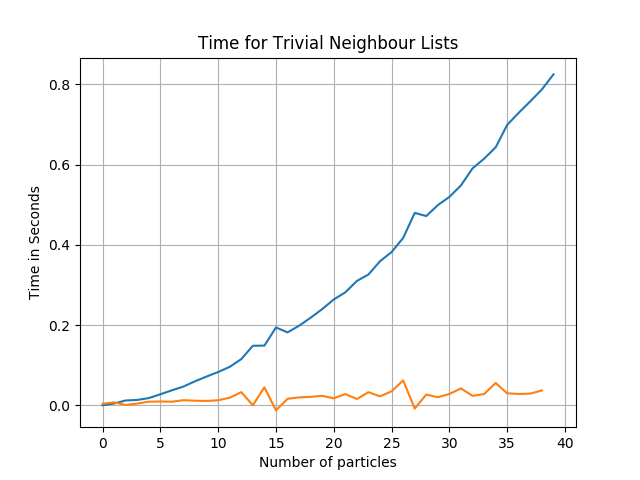

In [6]:
import time

times = []
N = 800
for i in range(10,N,N//40):
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,1600,neighbouring=False)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st)
    print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Trivial Neighbour Lists")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
times = np.array(times)
plt.plot(times)
plt.plot(times[1:]-times[:-1])
plt.grid()

In [7]:
times = []
N = 200

for i in range(10,N,(N//40)):
    # means we're using cell linked lists
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,1600,neighbouring=True)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st)
    print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Cell Linked Lists")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
times = np.array(times)
plt.plot(times)
plt.plot(times[1:]-times[:-1])
plt.grid()
plt.show()

10 particles, time:  0.0237070000000017  potential=  -0.0034731297546
15 particles, time:  0.019445000000001045  potential=  -0.0395765154671
20 particles, time:  0.03727699999999956  potential=  -0.624186854871
25 particles, time:  0.04755800000000221  potential=  0.899889134074
30 particles, time:  0.07502900000000068  potential=  -1.43928191481
35 particles, time:  0.1215349999999944  potential=  -3.55630862191
40 particles, time:  0.12607899999999717  potential=  -1.32024816948
45 particles, time:  0.1489440000000002  potential=  -0.951489958597
50 particles, time:  0.19305600000000567  potential=  1.67416247829
55 particles, time:  0.22219500000000636  potential=  2.71350488016
60 particles, time:  0.270153999999998  potential=  -1.12234660938
65 particles, time:  0.30978200000000555  potential=  16.3887554087
70 particles, time:  0.36392800000000136  potential=  1.21019075072
75 particles, time:  0.14422799999999825  potential=  -8.38425025708
80 particles, time:  0.1632309999999

KeyboardInterrupt: 

Time:  3.7000000000286803e-05
Time:  4.399999999993298e-05
Time:  9.599999999965192e-05
Time:  0.00017800000000001148
Time:  0.0002990000000000492
Time:  0.0005630000000000912
Time:  0.000656000000000212
Time:  0.0008889999999999176
Time:  0.0014449999999999186
Time:  0.0015870000000002271
Time:  0.0019259999999996502
Time:  0.0027880000000002347
Time:  0.002930000000000099
Time:  0.0033680000000000376
Time:  0.004310999999999954
Time:  0.004696999999999729
Time:  0.005592000000000041
Time:  0.0062349999999997685
Time:  0.0072830000000001505
Time:  0.008024999999999949
Time:  0.009300000000000086
Time:  0.010526000000000035
Time:  0.013792000000000026
Time:  0.012077000000000115
Time:  0.013454999999999995
Time:  0.01445300000000005
Time:  0.015511999999999748
Time:  0.017288999999999888
Time:  0.018440999999999708
Time:  0.020318999999999754
Time:  0.024713999999999903
Time:  0.02340999999999971
Time:  0.02477399999999985
Time:  0.026724000000000192
Time:  0.028291999999999984
Time:  

<IPython.core.display.Javascript object>


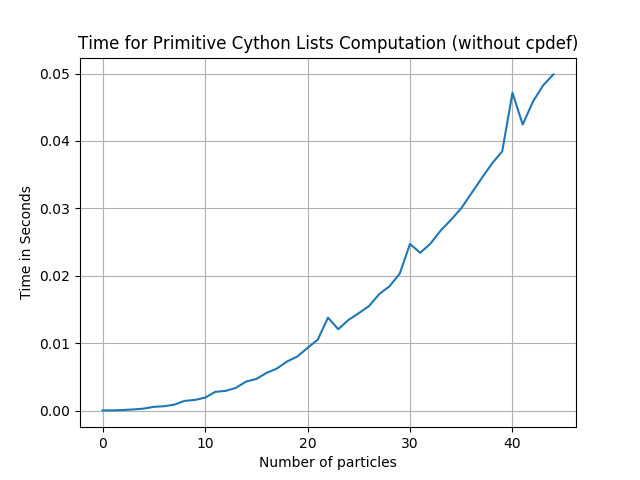

In [8]:
box_len = 5
nr_part = 900
times = []
import time

for i in range(10, nr_part, 20):
    dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")
    
    st = time.clock()
    fast_distances_cpdef(pos, box_len, dists)
    end = time.clock()
    times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Primitive Cython Lists Computation (without cpdef)")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
times = np.array(times)
plt.plot(times)
plt.grid()
plt.show()

#print("fast distances array: ", dists)